In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [3]:
#pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [6]:
#pip install seaborn

In [7]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [8]:
print(train.shape)
print(test.shape)

(42000, 785)
(28000, 784)


In [9]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Data Preprocessing 

In [11]:
y=train['label']
X=train.drop('label',axis=1)

print(X.shape)

(42000, 784)


In [14]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [15]:
from sklearn.model_selection import train_test_split


In [16]:
X=X.values.reshape(-1,28,28,1)
test=test.values.reshape(-1,28,28,1)

print(X.shape)
print(test.shape)

(42000, 28, 28, 1)
(28000, 28, 28, 1)


In [37]:
x_train,x_val,y_train,y_val=train_test_split(X,y,test_size=0.05,random_state=2)

x_test=test

In [38]:
print(x_train.shape)
print(y_train.shape)

(39900, 28, 28, 1)
(39900,)


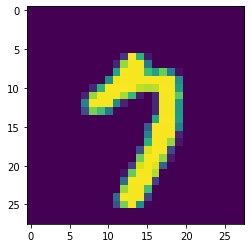

In [42]:
plt.imshow(x_train[5][:,:,0])

### Standardization and Normalization

In [46]:
X_train=np.array(x_train)
X_val=np.array(x_val)
X_test=np.array(x_test)

#standardization

#Xtrain
mean_px=X_train.mean().astype(np.float32)
std_px=X_train.std().astype(np.float32)

X_train=(X_train-mean_px)/(std_px)

#X_val
mean_px=X_val.mean().astype(np.float32)
std_px=X_val.std().astype(np.float32)

X_val=(X_val-mean_px)/(std_px)

#X_test
mean_px=X_test.mean().astype(np.float32)
std_px=X_test.std().astype(np.float32)

X_test=(X_test-mean_px)/(std_px)



In [48]:
#One hot encoding 
from tensorflow.keras.utils import to_categorical
y_train=to_categorical(y_train)
y_val=to_categorical(y_val)

print(y_train.shape)  #checck

(39900, 10)


In [49]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# By using the image generator, we are not generating new data. We are only replacing the exisiting images. 

datagen = ImageDataGenerator(
        featurewise_center = False,  # set input mean to 0 over the dataset
        samplewise_center = False,  # set each sample mean to 0
        featurewise_std_normalization = False,  # divide inputs by std of the dataset
        samplewise_std_normalization = False,  # divide each input by its std
        zca_whitening = False,  # apply ZCA whitening
        rotation_range = 10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range = 0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range = 0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = False,  # randomly flip images
        vertical_flip = False)  # randomly flip images


In [50]:
datagen.fit(X_train)

In [51]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

variable_learning_rate = ReduceLROnPlateau(monitor='val_loss', factor = 0.2, patience = 2)

# Model Building

In [54]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Activation, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2


[LeNet-5] Modified Architecture
ConvNet --> ConvNet --> BatchNorm --> Pool --> (Dropout) --> ConvNet --> ConvNet --> BatchNorm --> Pool --> (Dropout) --> (Flatten) --> FullyConnected --> BatchNorm --> FullyConnected --> BatchNorm --> FullyConnected --> BatchNorm --> (Dropout) --> Softmax

In [64]:
def LeNet5v2(input_shape = (28, 28, 1), classes = 10):
    """
    Implementation of a modified LeNet-5.
    Only those layers with learnable parameters are counted in the layer numbering.
    
    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    model = Sequential([
        
    # Layer 1
    Conv2D(filters = 32, kernel_size = 5, strides = 1, activation = 'relu', input_shape = (28,28,1), kernel_regularizer=l2(0.0005), name = 'convolution_1'),
    
    # Layer 2
    Conv2D(filters = 32, kernel_size = 5, strides = 1, name = 'convolution_2', use_bias=False),
    
    # Layer 3    
    BatchNormalization(name = 'batchnorm_1'),
        
    # -------------------------------- #  
    Activation("relu"),
    MaxPooling2D(pool_size = 2, strides = 2, name = 'max_pool_1'),
    Dropout(0.25, name = 'dropout_1'),
    # -------------------------------- #  
        
    # Layer 3
    Conv2D(filters = 64, kernel_size = 3, strides = 1, activation = 'relu', kernel_regularizer=l2(0.0005), name = 'convolution_3'),
        
    # Layer 4
    Conv2D(filters = 64, kernel_size = 3, strides = 1, name = 'convolution_4', use_bias=False),
        
    # Layer 5
    BatchNormalization(name = 'batchnorm_2'),
        
    # -------------------------------- #  
    Activation("relu"),
    MaxPooling2D(pool_size = 2, strides = 2, name = 'max_pool_2'),
    Dropout(0.25, name = 'dropout_2'),
    Flatten(name = 'flatten'),
    # -------------------------------- #  
        
    # Layer 6
    Dense(units = 256, name = 'fully_connected_1', use_bias=False),
        
    # Layer 7
    BatchNormalization(name = 'batchnorm_3'),
    
    # -------------------------------- #  
    Activation("relu"),
    # -------------------------------- #  
        
    # Layer 8
    Dense(units = 128, name = 'fully_connected_2', use_bias=False),
        
    # Layer 9
    BatchNormalization(name = 'batchnorm_4'),
        
    # -------------------------------- #  
    Activation("relu"),
    # -------------------------------- #  
        
    # Layer 10
    Dense(units = 84, name = 'fully_connected_3', use_bias=False),
        
    # Layer 11
    BatchNormalization(name = 'batchnorm_5'),
        
    # -------------------------------- #  
    Activation("relu"),
    Dropout(0.25, name = 'dropout_3'),
    # -------------------------------- #  

    # Output
    Dense(units = 10, activation = 'softmax', name = 'output')
        
    ])
    
    model._name = 'LeNet5v2'

    return model

In [65]:
LeNet5Model = LeNet5v2(input_shape = (28, 28, 1), classes = 10)

In [66]:
LeNet5Model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [67]:
LeNet5Model.summary()

Model: "LeNet5v2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
convolution_1 (Conv2D)       (None, 24, 24, 32)        832       
_________________________________________________________________
convolution_2 (Conv2D)       (None, 20, 20, 32)        25600     
_________________________________________________________________
batchnorm_1 (BatchNormalizat (None, 20, 20, 32)        128       
_________________________________________________________________
activation_5 (Activation)    (None, 20, 20, 32)        0         
_________________________________________________________________
max_pool_1 (MaxPooling2D)    (None, 10, 10, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 10, 32)        0         
_________________________________________________________________
convolution_3 (Conv2D)       (None, 8, 8, 64)          184

# Model Training

In [68]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(39900, 28, 28, 1)
(39900, 10)
(2100, 28, 28, 1)
(2100, 10)


In [69]:
print(type(X_train))
print(type(y_train))
print(type(X_val))
print(type(y_val))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
history = LeNet5Model.fit(X_train, y_train, epochs = 30, batch_size = 64)# callbacks = [variable_learning_rate], validation_data = (X_val,y_val))

Epoch 1/30
624/624 [==============================] - 161s 258ms/step - loss: 0.2783 - accuracy: 0.9251
Epoch 2/30
624/624 [==============================] - 166s 266ms/step - loss: 0.1045 - accuracy: 0.9754
Epoch 3/30
624/624 [==============================] - 199s 319ms/step - loss: 0.0836 - accuracy: 0.9795
Epoch 4/30
624/624 [==============================] - 196s 315ms/step - loss: 0.0713 - accuracy: 0.9835
Epoch 5/30
624/624 [==============================] - 203s 326ms/step - loss: 0.0634 - accuracy: 0.9851
Epoch 6/30
624/624 [==============================] - 204s 327ms/step - loss: 0.0557 - accuracy: 0.9868
Epoch 7/30
624/624 [==============================] - 202s 323ms/step - loss: 0.0549 - accuracy: 0.9868
Epoch 8/30
624/624 [==============================] - 217s 347ms/step - loss: 0.0543 - accuracy: 0.9866
Epoch 9/30
238/624 [==========>...................] - ETA: 2:14 - loss: 0.0544 - accuracy: 0.9870

In [ ]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.figure()

In [ ]:
#Submission 

results = LeNet5Model.predict(X_test)
results = np.argmax(results,axis = 1)
results = pd.Series(results,name="Label")

submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv("LeNetv2.csv",index=False)